bash command: `papermill 9b2_fulldata_01_run_models_run2.ipynb 9b2_fulldata_01_run_models_run2_out.ipynb`

# pycisTopic analysis

Full dataset, using SCREEN regions.

In [1]:
import pycisTopic
pycisTopic.__version__

'0.1.dev300+g7494158'

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
import pickle
import pandas as pd

In [4]:
import os
wdir = '/lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds_singles/'
os.chdir( wdir )

In [5]:
import glob
from collections import OrderedDict

In [6]:
# filenames = glob.glob('cistopic_objs__screen/*filtered.pkl')

filenames = [
    'cistopic_objs__screen/VIB_Hydrop_2__cistopic_obj_filtered.pkl',
    'cistopic_objs__screen/VIB_Hydrop_1__cistopic_obj_filtered.pkl',
]

In [7]:
samples = [item.replace("__cistopic_obj_filtered.pkl", "") for item in filenames]
samples = [item.replace("cistopic_objs__screen/", "") for item in samples]
files_dict = {samples[i]: filenames[i] for i in range(len(samples))}
files_dict = OrderedDict(sorted(files_dict.items()))
files_dict.keys()

odict_keys(['VIB_Hydrop_1', 'VIB_Hydrop_2'])

Create a dictionary with fragments files for each sample

# Read filtered cistopic objs

In [6]:
f_cto_dir = 'pycistopic_screen/cistopic_objs__screen'

cistopic_obj_dict = {}
for key in files_dict.keys():
    f_cto = os.path.join(wdir, f_cto_dir, key + '__cistopic_obj_filtered.pkl')
    if(os.path.isfile(f_cto)):
        with open(f_cto, 'rb') as f:
            cistopic_obj_dict[key] = pickle.load(f)
        print(f"Loaded filtered cistopic object {key}")
    else:
        print(f"file {f_cto} doesn't exist")

NameError: name 'files_dict' is not defined

# Run models for quick visualize/clustering

In [88]:
from pycisTopic.lda_models import run_cgs_models_mallet

#### mallet models

In [89]:
# set the memory limit for mallet (1GB default is not enough)
os.environ['MALLET_MEMORY'] = '100G'

In [90]:
f_mod_dir = 'models__screen__mallet'
if not os.path.exists(os.path.join(wdir, f_mod_dir)):
    os.makedirs(os.path.join(wdir, f_mod_dir))

n_topics = [50]
n_iter = 200

In [91]:
!pwd

/lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds


Make sure no previous traces are left from other mallet runs in tmp dir, otherwise it can try to re-load mallet tmp files

In [92]:
# mallet implementation
models_dict = {}
for key in cistopic_obj_dict.keys():
    f_mod = os.path.join(wdir, f_mod_dir, key + '__models_' + str(n_iter) + '_iter.pkl')
    if os.path.isfile(f_mod):
        print(f"Loading {f_mod}")
        with open(f_mod, 'rb') as f:
            models_dict[key] = pickle.load(f)
    else:
        print(f"Running {key}")
        model = run_cgs_models_mallet(
                            'mallet',
                            cistopic_obj_dict[key],
                            n_topics=n_topics,
                            n_cpu=32,
                            n_iter=n_iter,
                            random_state=555,
                            alpha=50,
                            alpha_by_topic=True,
                            eta=0.1,
                            eta_by_topic=False,
                            tmp_path=os.path.join('/tmp', key + '_mallet2')
                            )
        # Save
        with open(f_mod, 'wb') as f:
            pickle.dump(model, f)
        print(f"Finished {key}")
        models_dict[key] = model

Loading /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/models__screen__mallet/VIB_Hydrop_1__models_200_iter.pkl
Loading /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/models__screen__mallet/VIB_Hydrop_2__models_200_iter.pkl


### Read in LDA/mallett models

In [93]:
from pycisTopic.lda_models import evaluate_models
import matplotlib.pyplot as plt

In [94]:
f_mod_dir = 'models__screen__mallet'

models_dict = {}
for key in cistopic_obj_dict.keys():
    f_mod = os.path.join(wdir, f_mod_dir, key + '__models_' + str(n_iter) + '_iter.pkl')
    if(os.path.isfile(f_mod)):
        with open(f_mod, 'rb') as f:
            models_dict[key] = pickle.load(f)
        print(f"Loaded {key}")

Loaded VIB_Hydrop_1
Loaded VIB_Hydrop_2


In [95]:
for key in models_dict.keys():
    model=evaluate_models(models_dict[key],
                         select_model=50, 
                         return_model=True, 
                         metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                         plot=False, # disabled since we only test one model here
                         plot_metrics=False
                         )
    cistopic_obj_dict[key].add_LDA_model(model)

# dimensionality reduction

In [13]:
from pycisTopic.clust_vis import find_clusters, run_umap, run_tsne, plot_metadata, plot_topic

In [97]:
for key in cistopic_obj_dict.keys():
    find_clusters(cistopic_obj_dict[key],
              target  = 'cell',
              k = 10,
              res = [0.6, 0.8],
              prefix = 'pycisTopic_')
    cistopic_obj_dict[key].projections['cell'] = {}
    run_umap(cistopic_obj_dict[key], target = 'cell')
    #run_tsne(cistopic_obj_dict[key], target = 'cell')

2021-10-21 11:58:39,257 cisTopic     INFO     Finding neighbours
2021-10-21 11:58:40,877 cisTopic     INFO     Running UMAP
2021-10-21 11:59:11,189 cisTopic     INFO     Finding neighbours
2021-10-21 11:59:12,570 cisTopic     INFO     Running UMAP


In [99]:
for key in files_dict.keys():
    f_out = os.path.join(wdir, f_cto_dir, key + '__cistopic_obj_filtered_models.pkl')
    if os.path.isfile(f_out):
        print(f"Skipping {key}, already exists")
        continue
    with open(f_out, 'wb') as f:
        pickle.dump(cistopic_obj_dict[key], f)
    
    print(f"Generated and saved filtered cistopic object for {key}")

Generated and saved filtered cistopic object for VIB_Hydrop_1
Generated and saved filtered cistopic object for VIB_Hydrop_2


now re-read all the models, including the previously generated ones.

# here, perform seurat predictions
and save

In [9]:
f_cto_dir = 'pycistopic_screen/cistopic_objs__screen'

cistopic_obj_dict = {}
for key in files_dict.keys():
    f_cto = os.path.join(wdir, f_cto_dir, key + '__cistopic_obj_filtered_models.pkl')
    if(os.path.isfile(f_cto)):
        with open(f_cto, 'rb') as f:
            cistopic_obj_dict[key] = pickle.load(f)
        print(f"Loaded filtered cistopic object {key}")
    else:
        print(f"file {f_cto} doesn't exist")

Loaded filtered cistopic object VIB_Hydrop_1
Loaded filtered cistopic object VIB_Hydrop_2


# open cto

### Read in cell type predictions

In [11]:
f_pred_dir = 'pycistopic_screen/cell_type_classification/predictions/'

ct_pred = {}
for key in cistopic_obj_dict.keys():
    ct_pred[key] = pd.read_csv(os.path.join(f_pred_dir, key + '__cell_type_seurat.txt'),sep='\t')
    # format to add to cistopic object:
    ct_annot = ct_pred[key][['composite_sample_id','cell_type','cell_type_pred_score']].copy().set_index('composite_sample_id')
    ct_annot.columns = ['seurat_cell_type','seurat_cell_type_pred_score']
    cistopic_obj_dict[key].add_cell_data(ct_annot)

## Visualizations

VIB_Hydrop_1


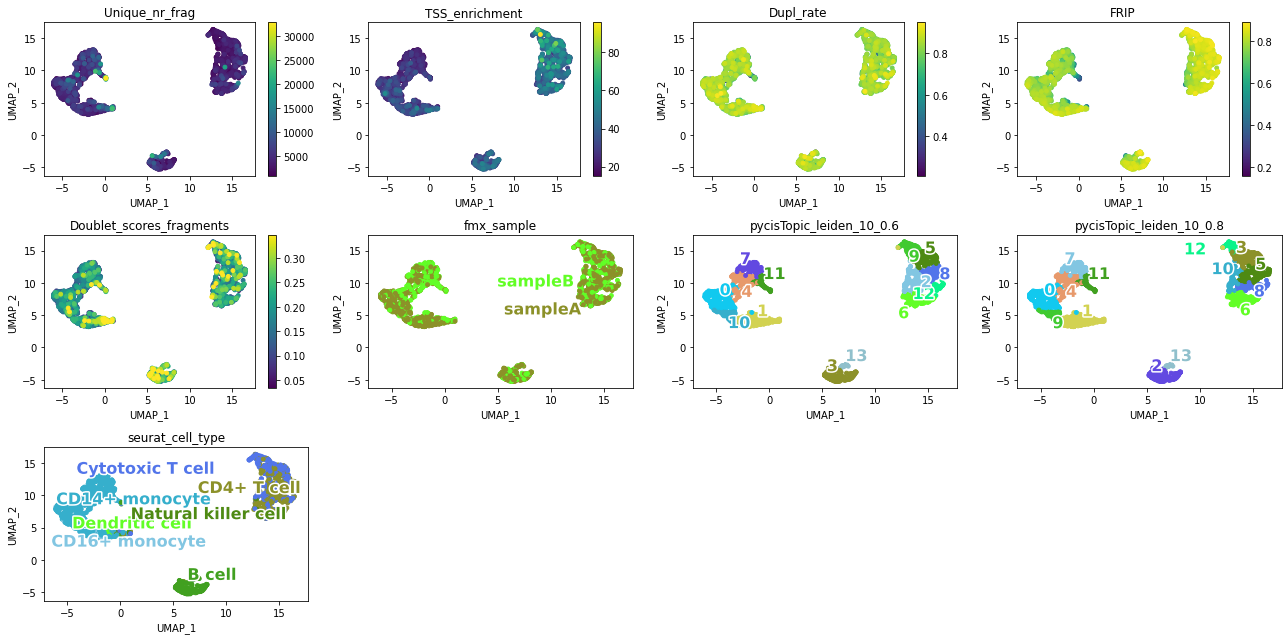

VIB_Hydrop_2


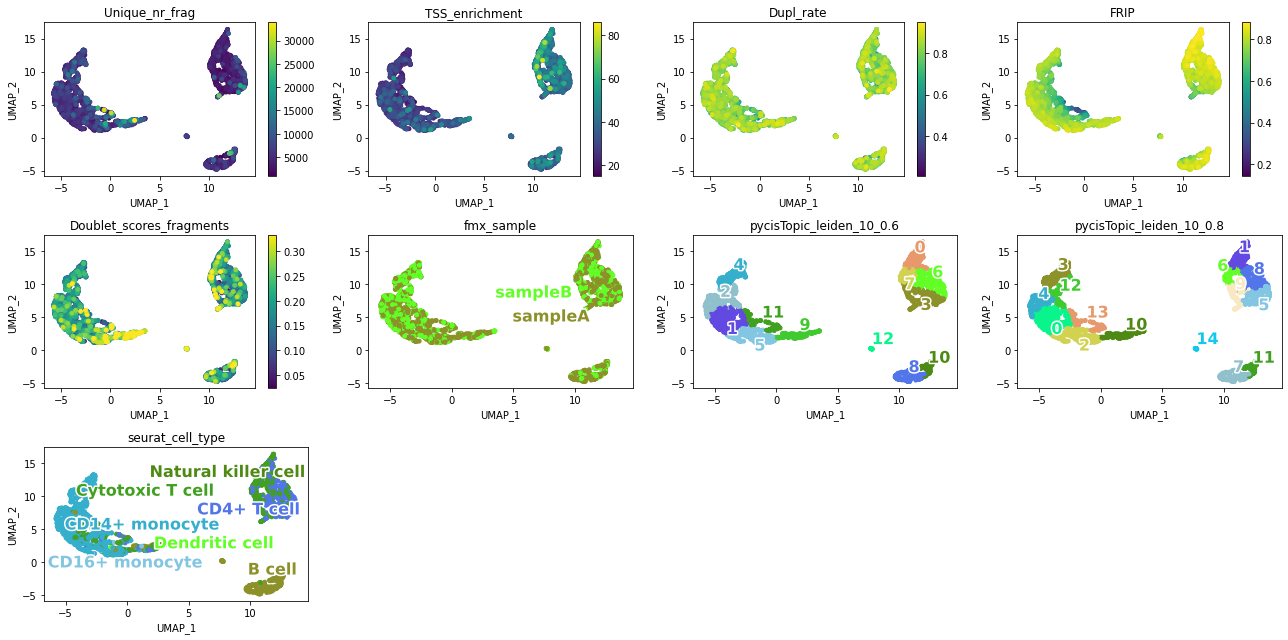

In [102]:
for key in cistopic_obj_dict.keys():
    print(key)
    plot_metadata(cistopic_obj_dict[key],
                  reduction_name='UMAP',
                  variables=['Unique_nr_frag', 'TSS_enrichment', 'Dupl_rate', 'FRIP',
                             'Doublet_scores_fragments', 'fmx_sample', 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_0.8', 'seurat_cell_type'],
                  target='cell',
                  num_columns=4,
                  text_size=16,
                  dot_size=15,
                  figsize=(18,9),
                 )

# Cluster-cell type consensus

Here we use the label transfer from Seurat to generate a consensus cell type for each cluster identified in each sample.

VIB_Hydrop_1


,cluster,major_cell_type,frac_of_cluster,next_celltype,next_frac_of_cluster,diff_to_next
VIB_Hydrop_1__10,10,CD4+ T cell,0.556701,Cytotoxic T cell,0.402062,0.154639
VIB_Hydrop_1__5,5,CD4+ T cell,0.534031,Cytotoxic T cell,0.465969,0.068063


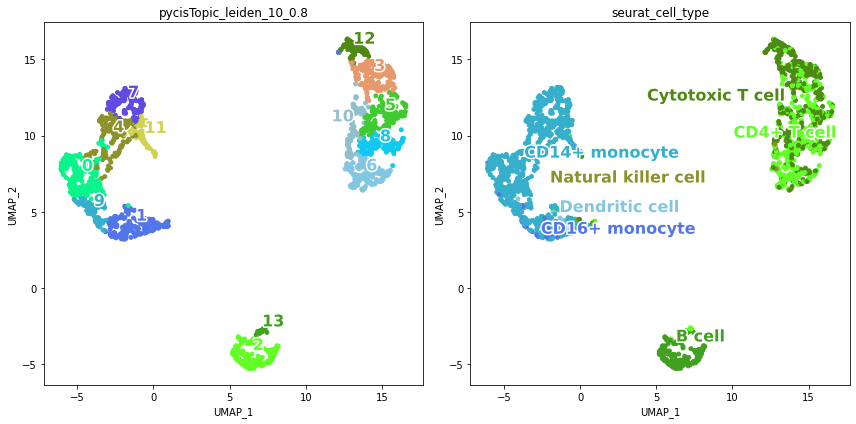

VIB_Hydrop_2


,cluster,major_cell_type,frac_of_cluster,next_celltype,next_frac_of_cluster,diff_to_next
VIB_Hydrop_2__13,13,CD14+ monocyte,0.461538,Cytotoxic T cell,0.318681,0.142857
VIB_Hydrop_2__10,10,Cytotoxic T cell,0.372263,CD4+ T cell,0.262774,0.109489


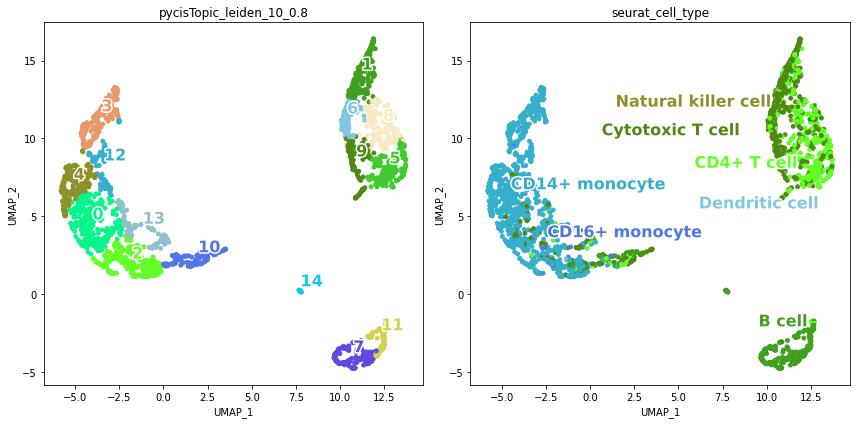

In [14]:
clustering='pycisTopic_leiden_10_0.8'
ct_pred_thr=0.7

clust_consensus = {}
for key in cistopic_obj_dict.keys():
    if key=='merged':
        continue
    celldata = cistopic_obj_dict[key].cell_data

    major_cell_type = []
    frac_of_cluster = []
    next_celltype = []
    next_frac_of_cluster = []
    diff_to_next = []

    for c in celldata[clustering].unique():
        c1 = celldata[celldata[clustering]==c]
        # find proportions of each unique cell type detected in this cluster:
        ctp = pd.DataFrame([
            c1['seurat_cell_type'].unique(),
            [ c1[c1['seurat_cell_type']==x].shape[0] / c1.shape[0] for x in c1['seurat_cell_type'].unique() ]
        ]).T
        # sort/rank by proportion:
        ctps = ctp.sort_values(1,ascending=False)
        if ctp.shape[0]>1:
            n = ctps.iloc[1,0] # next cell type detected
            dtn = ctps.iloc[0,1] - ctps.iloc[1,1] # distance to next
            dtnf = ctps.iloc[1,1]
        else:
            dtn = None
            dtnf = None
            n = None
        major_cell_type.append(ctps.iloc[0,0])
        frac_of_cluster.append(ctps.iloc[0,1])
        next_celltype.append(n)
        next_frac_of_cluster.append(dtnf)
        diff_to_next.append(dtn)
        
    # collect results for this sample
    res = pd.DataFrame([
            celldata[clustering].unique(),
            major_cell_type,
            frac_of_cluster,
            #
            next_celltype,
            next_frac_of_cluster,
            diff_to_next,
        ]).T.set_axis(
            ['cluster', 'major_cell_type', 'frac_of_cluster', 
             'next_celltype', 'next_frac_of_cluster', 'diff_to_next'],
            axis=1
        ).set_index(key + '__' + celldata[clustering].unique())
    clust_consensus[key] = res
    print(key)
    # print only rows where there is another cell type within 20%:
    if(sum(res['diff_to_next']<0.20)>0):
        display(res[ res['diff_to_next']<0.20 ])
        plot_metadata(cistopic_obj_dict[key],
                      reduction_name='UMAP',
                      variables=[clustering, 'seurat_cell_type'],
                      target='cell',
                      num_columns=2,
                      text_size=16,
                      dot_size=15,
                      figsize=(12,6),
                     )
    else:
        print("No discrepant clusters")

In [ ]:
#clust_consensus = pd.concat(clust_consensus, axis=0)
clust_consensus['CNAG_1']

### Add cluster-based cell identities to the cisTopic object

In [104]:
for key in cistopic_obj_dict.keys():
    if key=='merged':
        continue
    cistopic_obj_dict[key].cell_data['consensus_cell_type'] = ""
    # add each cluster identity:
    for i,r in clust_consensus[key].iterrows():
        ix = cistopic_obj_dict[key].cell_data[clustering] == r['cluster']
        cistopic_obj_dict[key].cell_data.loc[ix,'consensus_cell_type'] = r['major_cell_type']

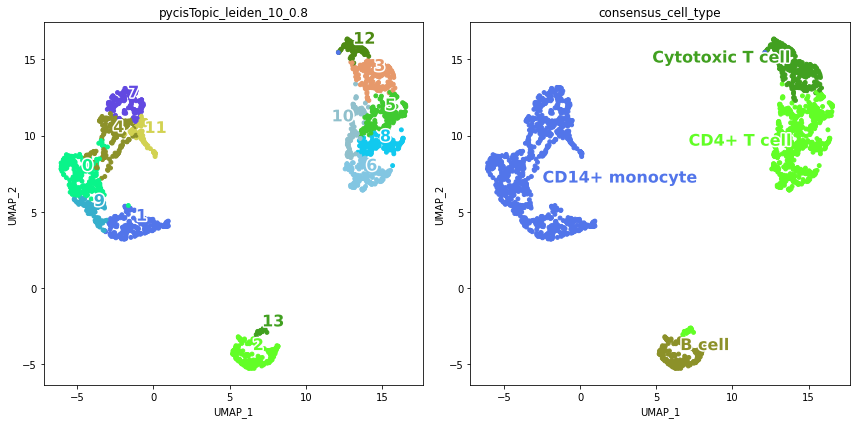

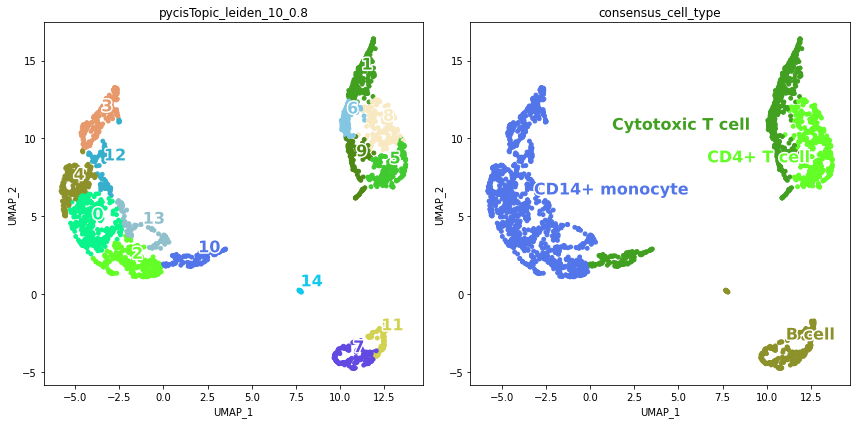

In [16]:
for key in cistopic_obj_dict.keys():
    plot_metadata(cistopic_obj_dict[key],
                  reduction_name='UMAP',
                  variables=[clustering, 'consensus_cell_type'],
                  target='cell',
                  num_columns=2,
                  text_size=16,
                  dot_size=15,
                  figsize=(12,6),
                 )

In [105]:
for key in files_dict.keys():
    f_out = os.path.join(wdir, f_cto_dir, key + '__cistopic_obj_filtered_models_annotated.pkl')
    if os.path.isfile(f_out):
        print(f"Skipping {key}, already exists")
        continue
    with open(f_out, 'wb') as f:
        pickle.dump(cistopic_obj_dict[key], f)
    
    print(f"Generated and saved filtered cistopic object for {key}")

Generated and saved filtered cistopic object for VIB_Hydrop_1
Generated and saved filtered cistopic object for VIB_Hydrop_2


## load cisTopic objects

now re-read all the models, including the previously generated ones.

In [15]:
f_cto_dir = 'pycistopic_screen/cistopic_objs__screen'

cistopic_obj_dict = {}
for key in files_dict.keys():
    f_cto = os.path.join(wdir, f_cto_dir, key + '__cistopic_obj_filtered_models_annotated.pkl')
    if(os.path.isfile(f_cto)):
        with open(f_cto, 'rb') as f:
            cistopic_obj_dict[key] = pickle.load(f)
        print(f"Loaded filtered cistopic object {key}")
    else:
        print(f"file {f_cto} doesn't exist")

Loaded filtered cistopic object VIB_Hydrop_1
Loaded filtered cistopic object VIB_Hydrop_2


In [15]:
cistopic_obj_dict

{'VIB_Hydrop_1': <pycisTopic.cistopic_class.CistopicObject at 0x2b3bb3e52370>,
 'VIB_Hydrop_2': <pycisTopic.cistopic_class.CistopicObject at 0x2b3c62a74fa0>}

In [36]:
# export filtered set of barcodes (without doublets, etc)
bc_passing_filters2 = {}
for key in cistopic_obj_dict.keys():
    if(key == 'merged'):
        continue
    bc_passing_filters2[key] = cistopic_obj_dict[key].cell_data['barcode'].tolist()

with open(os.path.join(wdir,'pycistopic_screen/barcodes_passing_filters_filtered.pkl'), 'wb') as f:
    pickle.dump(bc_passing_filters2, f)

In [ ]:
# export filtered set of barcodes (without doublets, etc)
bc_passing_filters2 = {}
for key in cistopic_obj_dict.keys():
    if(key == 'merged'):
        continue
    bc_passing_filters2[key] = cistopic_obj_dict[key].cell_data['barcode'].tolist()

with open(os.path.join(wdir,'pycistopic_screen/barcodes_passing_filters_filtered.pkl'), 'wb') as f:
    pickle.dump(bc_passing_filters2, f)

# save the metadata!!
need this for consensus cell types

In [13]:
for key in cistopic_obj_dict.keys():
    cistopic_obj_dict[key].cell_data.to_csv(
        os.path.join(wdir,'pycistopic_screen',key+'_cell_data.tsv'),
        sep='\t'
    )

## Export pseudobulk profiles

In [16]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk, peak_calling
import pyranges as pr
import requests

In [17]:
# get chromosome sizes (hg38)
target_url = 'http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes = pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns = ['Chromosome', 'End']
chromsizes['Start'] = [0]*chromsizes.shape[0]
chromsizes = chromsizes.loc[:,['Chromosome', 'Start', 'End']]
chromsizes = pr.PyRanges(chromsizes)
chromsizes

,Chromosome,Start,End
0,chr1,0,248956422
1,chr1_GL383518v1_alt,0,182439
2,chr1_GL383519v1_alt,0,110268
3,chr1_GL383520v2_alt,0,366580
4,chr1_KI270706v1_random,0,175055
...,...,...,...
450,chrX_KI270880v1_alt,0,284869
451,chrX_KI270881v1_alt,0,144206
452,chrX_KI270913v1_alt,0,274009
453,chrY,0,57227415


In [28]:
import ray
bw_paths_dict = {}
bed_paths_dict = {}
ray.shutdown()
for key in cistopic_obj_dict.keys():
    print(f"Starting {key}")
    f_dir = os.path.join(wdir, f_pseudo_dir, key)
    if not os.path.exists(f_dir):
        os.makedirs(f_dir)
        
    f_bw = os.path.join(f_dir, 'bw_paths.pkl')
    f_bed = os.path.join(f_dir, 'bed_paths.pkl')
    
    if(os.path.isfile(f_bw)):
        with open(f_bw, 'rb') as f:
            bw_paths_dict = pickle.load(f)
        with open(f_bed, 'rb') as f:
            bed_paths_dict = pickle.load(f)
        print(f"Loaded bw and bed paths for {key}")
    else:
        print(f"file {f_bw} doesn't exist, generating")
        print(f"file {f_bed} doesn't exist, generating")

        bw_paths, bed_paths = export_pseudobulk(
                    #input_data = cistopic_obj_dict['merged'].cell_data,
                    input_data = cistopic_obj_dict[key],
                    variable = 'consensus_cell_type',
                    sample_id_col = 'sample_id',
                    chromsizes = chromsizes,
                    bed_path = os.path.join(f_dir, 'pseudobulk_bed_files'),
                    bigwig_path =  os.path.join(f_dir, 'pseudobulk_bw_files'),
                    #path_to_fragments = fr_dict,
                    n_cpu = 5,
                    normalize_bigwig = True,
                    remove_duplicates = True,
                    _temp_dir = '/scratch/leuven/330/vsc33042/ray_spill'
                    )
        bw_paths_dict[key] = bw_paths.copy()
        bed_paths_dict[key] = bed_paths.copy()
        with open(f_bw, 'wb') as f:
            pickle.dump(bw_paths, f)
        with open(f_bed, 'wb') as f:
            pickle.dump(bed_paths, f)
        print(f"Finished {key}")
    if ray.is_initialized():
        print("Shutting down Ray")
        ray.shutdown()

f_dir = os.path.join(wdir, f_pseudo_dir)
f_bw_dict = os.path.join(f_dir, 'bw_paths_dict.pkl')
f_bed_dict = os.path.join(f_dir, 'bed_paths_dict.pkl')

with open(f_bw_dict, 'wb') as f:
    pickle.dump(bw_paths_dict, f)
with open(f_bed_dict, 'wb') as f:
    pickle.dump(bed_paths_dict, f)

Starting VIB_Hydrop_1
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_1/bw_paths.pkl doesn't exist, generating
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_1/bed_paths.pkl doesn't exist, generating
2021-10-21 14:10:35,103 cisTopic     INFO     Reading fragments from fragments_postbap/VIB_Hydrop_1.sinto.mm.fragments.tsv.gz


2021-10-21 14:11:19,932	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-21 14:12:29,311	WARNING worker.py:1215 -- The autoscaler failed with the following error:
Traceback (most recent call last):
  File "/opt/venv/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 324, in run
    self._run()
  File "/opt/venv/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 214, in _run
    self.update_load_metrics()
  File "/opt/venv/lib/python3.8/site-packages/ray/autoscaler/_private/monitor.py", line 176, in update_load_metrics
    response = self.gcs_node_resources_stub.GetAllResourceUsage(
  File "/opt/venv/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/opt/venv/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpc

(pid=23014) 2021-10-21 14:12:29,152 cisTopic     INFO     Creating pseudobulk for CytotoxicTcell
(pid=23015) 2021-10-21 14:12:29,171 cisTopic     INFO     Creating pseudobulk for CD14_monocyte
(pid=23018) 2021-10-21 14:12:29,152 cisTopic     INFO     Creating pseudobulk for CD4_Tcell
(pid=23014) 2021-10-21 14:12:49,173 cisTopic     INFO     CytotoxicTcell done!
(pid=23017) 2021-10-21 14:12:53,524 cisTopic     INFO     Creating pseudobulk for Bcell
(pid=23018) 2021-10-21 14:13:03,411 cisTopic     INFO     CD4_Tcell done!
(pid=23017) 2021-10-21 14:13:06,875 cisTopic     INFO     Bcell done!
(pid=23015) 2021-10-21 14:13:43,282 cisTopic     INFO     CD14_monocyte done!
Finished VIB_Hydrop_1
Starting VIB_Hydrop_2
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_2/bw_paths.pkl doesn't exist, generating
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_2/bed_paths.pkl doe

2021-10-21 14:14:33,925	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=25902) 2021-10-21 14:15:25,686 cisTopic     INFO     Creating pseudobulk for Bcell
(pid=25899) 2021-10-21 14:15:25,687 cisTopic     INFO     Creating pseudobulk for CD4_Tcell
(pid=25901) 2021-10-21 14:15:25,744 cisTopic     INFO     Creating pseudobulk for CD14_monocyte
(pid=25898) 2021-10-21 14:15:34,286 cisTopic     INFO     Creating pseudobulk for CytotoxicTcell
(pid=25902) 2021-10-21 14:15:44,560 cisTopic     INFO     Bcell done!
(pid=25899) 2021-10-21 14:15:45,975 cisTopic     INFO     CD4_Tcell done!
(pid=25898) 2021-10-21 14:16:09,619 cisTopic     INFO     CytotoxicTcell done!
(pid=25901) 2021-10-21 14:16:40,709 cisTopic     INFO     CD14_monocyte done!
Finished VIB_Hydrop_2


# non normalized bigwigs

In [22]:
f_pseudo_dir = 'pycistopic_screen/consensus_peak_calling_nonnormalized'
if not os.path.exists(os.path.join(wdir, f_pseudo_dir)):
    os.makedirs(os.path.join(wdir, f_pseudo_dir))

In [23]:
import ray
bw_paths_dict = {}
bed_paths_dict = {}
ray.shutdown()
for key in cistopic_obj_dict.keys():
    print(f"Starting {key}")
    f_dir = os.path.join(wdir, f_pseudo_dir, key)
    if not os.path.exists(f_dir):
        os.makedirs(f_dir)
        
    f_bw = os.path.join(f_dir, 'bw_paths.pkl')
    f_bed = os.path.join(f_dir, 'bed_paths.pkl')
    
    if(os.path.isfile(f_bw)):
        with open(f_bw, 'rb') as f:
            bw_paths_dict = pickle.load(f)
        with open(f_bed, 'rb') as f:
            bed_paths_dict = pickle.load(f)
        print(f"Loaded bw and bed paths for {key}")
    else:
        print(f"file {f_bw} doesn't exist, generating")
        print(f"file {f_bed} doesn't exist, generating")

        bw_paths, bed_paths = export_pseudobulk(
                    #input_data = cistopic_obj_dict['merged'].cell_data,
                    input_data = cistopic_obj_dict[key],
                    variable = 'consensus_cell_type',
                    sample_id_col = 'sample_id',
                    chromsizes = chromsizes,
                    bed_path = os.path.join(f_dir, 'pseudobulk_bed_files'),
                    bigwig_path =  os.path.join(f_dir, 'pseudobulk_bw_files'),
                    #path_to_fragments = fr_dict,
                    n_cpu = 5,
                    normalize_bigwig = False,
                    remove_duplicates = True,
                    _temp_dir = '/scratch/leuven/330/vsc33042/ray_spill'
                    )
        bw_paths_dict[key] = bw_paths.copy()
        bed_paths_dict[key] = bed_paths.copy()
        with open(f_bw, 'wb') as f:
            pickle.dump(bw_paths, f)
        with open(f_bed, 'wb') as f:
            pickle.dump(bed_paths, f)
        print(f"Finished {key}")
    if ray.is_initialized():
        print("Shutting down Ray")
        ray.shutdown()

f_dir = os.path.join(wdir, f_pseudo_dir)
f_bw_dict = os.path.join(f_dir, 'bw_paths_dict.pkl')
f_bed_dict = os.path.join(f_dir, 'bed_paths_dict.pkl')

with open(f_bw_dict, 'wb') as f:
    pickle.dump(bw_paths_dict, f)
with open(f_bed_dict, 'wb') as f:
    pickle.dump(bed_paths_dict, f)

Starting VIB_Hydrop_1
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds_singles/pycistopic_screen/consensus_peak_calling_nonnormalized/VIB_Hydrop_1/bw_paths.pkl doesn't exist, generating
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds_singles/pycistopic_screen/consensus_peak_calling_nonnormalized/VIB_Hydrop_1/bed_paths.pkl doesn't exist, generating
2021-11-10 17:52:42,963 cisTopic     INFO     Reading fragments from fragments_postbap/VIB_Hydrop_1.sinto.mm.fragments.tsv.gz


2021-11-10 17:53:14,040	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=20837) 2021-11-10 17:53:18,038 cisTopic     INFO     Creating pseudobulk for CytotoxicTcell
(pid=20835) 2021-11-10 17:53:17,954 cisTopic     INFO     Creating pseudobulk for CD4_Tcell
(pid=20836) 2021-11-10 17:53:17,966 cisTopic     INFO     Creating pseudobulk for CD14_monocyte
(pid=20838) 2021-11-10 17:53:17,973 cisTopic     INFO     Creating pseudobulk for Bcell
(pid=20837) 2021-11-10 17:53:29,484 cisTopic     INFO     CytotoxicTcell done!
(pid=20838) 2021-11-10 17:53:30,338 cisTopic     INFO     Bcell done!
(pid=20835) 2021-11-10 17:53:48,005 cisTopic     INFO     CD4_Tcell done!
Finished VIB_Hydrop_1
Starting VIB_Hydrop_2
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds_singles/pycistopic_screen/consensus_peak_calling_nonnormalized/VIB_Hydrop_2/bw_paths.pkl doesn't exist, generating
file /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds_singles/pycistopic_screen/consensus_peak_calling_nonnormalized/VIB_Hydrop_2/bed_paths.pkl d

2021-11-10 17:55:11,318	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=21986) 2021-11-10 17:55:15,279 cisTopic     INFO     Creating pseudobulk for CD14_monocyte
(pid=21984) 2021-11-10 17:55:15,221 cisTopic     INFO     Creating pseudobulk for CD4_Tcell
(pid=21983) 2021-11-10 17:55:15,240 cisTopic     INFO     Creating pseudobulk for CytotoxicTcell
(pid=21987) 2021-11-10 17:55:15,236 cisTopic     INFO     Creating pseudobulk for Bcell
(pid=21987) 2021-11-10 17:55:32,142 cisTopic     INFO     Bcell done!
(pid=21984) 2021-11-10 17:55:33,888 cisTopic     INFO     CD4_Tcell done!
(pid=21983) 2021-11-10 17:55:53,682 cisTopic     INFO     CytotoxicTcell done!
Finished VIB_Hydrop_2


### Infer consensus peaks

In [29]:
#Infer consensus peaks

f_dir = os.path.join(wdir, f_pseudo_dir)
f_bw = os.path.join(f_dir, 'bw_paths_dict.pkl')
f_bed = os.path.join(f_dir, 'bed_paths_dict.pkl')

if(os.path.isfile(f_bw_dict)):
    with open(f_bw_dict, 'rb') as f:
        bw_paths_dict = pickle.load(f)
    with open(f_bed_dict, 'rb') as f:
        bed_paths_dict = pickle.load(f)
    print(f"Loaded bw and bed paths for {key}")
else:
    print(f"file {f_bw} doesn't exist!")
    print(f"file {f_bed} doesn't exist!")

Loaded bw and bed paths for VIB_Hydrop_2


In [30]:
narrow_peaks_dict = {}
for key in cistopic_obj_dict.keys():
    print(f"Starting {key}")
    f_dir = os.path.join(wdir, f_pseudo_dir, key, 'macs2')
    if not os.path.exists(f_dir):
        os.makedirs(f_dir)

    # Run peak calling
    narrow_peaks_dict[key] = peak_calling('macs2',
                                     bed_paths_dict[key],
                                     f_dir,
                                     genome_size='hs',
                                     n_cpu=5,
                                     input_format='BEDPE',
                                     shift=73, 
                                     ext_size=146,
                                     keep_dup = 'all',
                                     q_value = 0.05,
                                      _temp_dir = '/scratch/leuven/330/vsc33042/ray_spill'
                                     )

Starting VIB_Hydrop_1


2021-10-21 14:16:53,846	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=28024) 2021-10-21 14:17:34,508 cisTopic     INFO     Calling peaks for CD4_Tcell with macs2 callpeak --treatment /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_1/pseudobulk_bed_files/CD4_Tcell.bed.gz --name CD4_Tcell  --outdir /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_1/macs2 --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(pid=28025) 2021-10-21 14:17:34,509 cisTopic     INFO     Calling peaks for CD14_monocyte with macs2 callpeak --treatment /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_1/pseudobulk_bed_files/CD14_monocyte.bed.gz --name CD14_monocyte  --outdir /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_1/macs2 --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 -

2021-10-21 14:18:34,800	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=29744) 2021-10-21 14:19:05,476 cisTopic     INFO     Calling peaks for CD14_monocyte with macs2 callpeak --treatment /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_2/pseudobulk_bed_files/CD14_monocyte.bed.gz --name CD14_monocyte  --outdir /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_2/macs2 --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(pid=29743) 2021-10-21 14:19:05,476 cisTopic     INFO     Calling peaks for CytotoxicTcell with macs2 callpeak --treatment /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_2/pseudobulk_bed_files/CytotoxicTcell.bed.gz --name CytotoxicTcell  --outdir /lustre1/project/stg_00002/lcb/fderop/data/20211013_hca_benchmark_libds/consensus_peak_calling/VIB_Hydrop_2/macs2 --format BEDPE --gsize hs --qvalue 0.05 --nomod

### Derive the consensus peaks

In [ ]:
path_to_blacklist

In [31]:
from pycisTopic.iterative_peak_calling import get_consensus_peaks

In [33]:
# make sure that this is the same one as used to create the CTOs!!!
# path_to_blacklist = '/staging/leuven/stg_00002/lcb/cflerin/testruns/pycisTopic/pycisTopic/blacklist/hg38-blacklist.v2.bed'
path_to_blacklist = 'hg38_regions/hg38-blacklist.v2.bed'

In [34]:
peak_half_width = 250

# Get consensus peaks
consensus_peaks_dict = {}
for key in cistopic_obj_dict.keys():
    print(f"Starting {key}")
    f_dir = os.path.join(wdir, f_pseudo_dir, key)
    if not os.path.exists(f_dir):
        os.makedirs(f_dir)
        
    consensus_peaks_dict[key] = get_consensus_peaks(
        narrow_peaks_dict[key],
        peak_half_width,
        chromsizes = chromsizes,
        path_to_blacklist = path_to_blacklist
    )
    consensus_peaks_dict[key].to_bed(
        path=os.path.join(f_dir, key + '__consensus_regions.bed'),
        keep=True,
        compression='infer',
        chain=False
    )

Starting VIB_Hydrop_1
2021-10-21 14:22:57,766 cisTopic     INFO     Extending and merging peaks per class
2021-10-21 14:23:28,160 cisTopic     INFO     Normalizing peak scores
2021-10-21 14:23:28,524 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2021-10-21 14:23:54,184 cisTopic     INFO     Done!
Starting VIB_Hydrop_2
2021-10-21 14:23:54,883 cisTopic     INFO     Extending and merging peaks per class
2021-10-21 14:24:27,938 cisTopic     INFO     Normalizing peak scores
2021-10-21 14:24:28,515 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2021-10-21 14:25:00,065 cisTopic     INFO     Done!


# now continue with the analysis, but using the consensus cell types

In [35]:
f_dir = os.path.join(wdir, f_pseudo_dir)
f_consensus_dict = os.path.join(f_dir, 'consensus_peaks_dict.pkl')
if(os.path.isfile(f_consensus_dict)):
    print("consensus peaks dict already exists!")
else:
    print(f"file consensus peaks dict doesn't exist, writing")
    with open(f_consensus_dict, 'wb') as f:
        pickle.dump(consensus_peaks_dict, f)
    print(f"Finished {key}")

file consensus peaks dict doesn't exist, writomg
Finished VIB_Hydrop_2


# write the consensus cell types into a dict.

In [41]:
meta1 = cistopic_obj_dict['VIB_Hydrop_1'].cell_data
meta2 = cistopic_obj_dict['VIB_Hydrop_2'].cell_data

In [49]:
meta_concat = pd.concat([meta1, meta2], axis=0, ignore_index=False)
meta_concat

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,Log_total_nr_frag,Log_unique_nr_frag,Total_nr_frag,Unique_nr_frag,Dupl_nr_frag,...,barcode,fmx_droplet_type,fmx_sample,Doublet_scores_fragments,Predicted_doublets_fragments,pycisTopic_leiden_10_0.6,pycisTopic_leiden_10_0.8,seurat_cell_type,seurat_cell_type_pred_score,consensus_cell_type
GTTAAGAACGTAGTGTCAGA-12-VIB_Hydrop_1,2815,3.449478,2691,3.429914,VIB_Hydrop_1,3.977906,3.499824,9504,3161,6343,...,GTTAAGAACGTAGTGTCAGA-12,SNG,sampleA,0.079365,False,10,9,CD14+ monocyte,0.805399,CD14+ monocyte
GGTACTCATTTACTGATAGC-11-VIB_Hydrop_1,1977,3.296007,1890,3.276462,VIB_Hydrop_1,3.998913,3.330617,9975,2141,7834,...,GGTACTCATTTACTGATAGC-11,SNG,sampleA,0.12297,False,1,1,CD14+ monocyte,0.389450,CD14+ monocyte
GTCGTTGAGATGCGTAGTAA-12-VIB_Hydrop_1,5101,3.707655,4791,3.680426,VIB_Hydrop_1,4.411771,3.753506,25809,5669,20140,...,GTCGTTGAGATGCGTAGTAA-12,SNG,sampleA,0.16763,False,0,0,CD14+ monocyte,0.391287,CD14+ monocyte
GTGGTATCCTTGACCGGAAC-12-VIB_Hydrop_1,1930,3.285557,1832,3.262925,VIB_Hydrop_1,4.120607,3.353916,13201,2259,10942,...,GTGGTATCCTTGACCGGAAC-12,SNG,sampleB,0.179331,False,2,10,CD4+ T cell,0.456999,CD4+ T cell
CATTGGTGCAACGGTGGACA-12-VIB_Hydrop_1,3877,3.588496,3670,3.564666,VIB_Hydrop_1,4.389644,3.634376,24527,4309,20218,...,CATTGGTGCAACGGTGGACA-12,SNG,sampleA,0.138539,False,4,4,CD14+ monocyte,0.678991,CD14+ monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAACTCACAGCTTAGCACTC-22-VIB_Hydrop_2,898,2.953276,868,2.93852,VIB_Hydrop_2,3.648653,2.981819,4453,959,3494,...,TAACTCACAGCTTAGCACTC-22,SNG,sampleA,0.076923,False,7,6,CD4+ T cell,0.464026,Cytotoxic T cell
CTTGGCAAGCTCCTGATAAG-21-VIB_Hydrop_2,1331,3.124178,1263,3.101403,VIB_Hydrop_2,3.712229,3.154424,5155,1427,3728,...,CTTGGCAAGCTCCTGATAAG-21,SNG,sampleA,0.066667,False,0,1,Cytotoxic T cell,0.539867,Cytotoxic T cell
GCACACAGTCTCCGGTCAAG-22-VIB_Hydrop_2,1128,3.052309,1084,3.035029,VIB_Hydrop_2,3.719414,3.070776,5241,1177,4064,...,GCACACAGTCTCCGGTCAAG-22,SNG,sampleA,0.127753,False,6,8,Cytotoxic T cell,0.439248,CD4+ T cell
ATCGTGCCTACCACACGGAT-22-VIB_Hydrop_2,1396,3.144885,1376,3.138618,VIB_Hydrop_2,3.973497,3.205204,9408,1604,7804,...,ATCGTGCCTACCACACGGAT-22,SNG,sampleB,0.084746,False,2,12,CD14+ monocyte,0.510324,CD14+ monocyte


In [47]:
len(cistopic_obj_dict['VIB_Hydrop_1'].cell_data) + len(cistopic_obj_dict['VIB_Hydrop_2'].cell_data)

4739

so this is correct. now write it.

In [54]:
meta_concat.to_csv(
    os.path.join(wdir,'pycistopic_screen/filtered_cell_data.tsv'),
    sep='\t'
)